In [66]:
%pip install tsfresh --user

Note: you may need to restart the kernel to use updated packages.


In [67]:
import matplotlib.pyplot as plt
import sys
import numpy
import os
import glob
import fnmatch
import pandas as pd
import neurokit2 as nk
from datetime import datetime, timedelta, timezone
from scipy import signal

numpy.set_printoptions(threshold=sys.maxsize)
plt.rcParams["figure.figsize"] = (25,20)

### Functions to get start time

In [68]:
def convert_time(time_str):
    # Convert the string to a datetime object
    time_obj = datetime.strptime(time_str, '%I:%M:%S %p')
    # Convert the time to 24-hour format
    timestampo = timedelta(hours=time_obj.hour, minutes= time_obj.minute, seconds=time_obj.second)
    print(F"target: {timestampo}")

    return timestampo

def get_time_from_line(line):
    # Extract mm:ss part from the line
    time_str = line.split('Start Time: ')[1].strip()
    time_str = convert_time(time_str)
    return time_str

def find_index_in_dataframe(text_file, start_timestamp, Hz):
    # Read the text file and extract the mm:ss time
    target_time = None
    with open(text_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('Start Time: '):
                time = get_time_from_line(line)
                if time:
                    target_time = time
                    break

    if target_time:
        # Find the index of the row with the target time
        start_time = start_timestamp
        start_time = timedelta(hours=start_time.hour ,minutes= start_time.minute, seconds=start_time.second)
        print(f"starting: {start_time}")
        print(f"diff: {(target_time - start_time).seconds}")
         
        time_diff = (target_time - start_time).seconds 
         
        
        index = 0 
        if  time_diff < 1800 : index = time_diff * Hz

        return index
    else:
        print("no target time")
        return None

## Load and get starting indexes

In [69]:
path_eda = "./dataset/P*/E4/EDA.csv"
path_ppg = "./dataset/P*/E4/BVP.csv"
path_acc = "./dataset/P*/EARBUDS/*imu-right.csv"

eda_all = []
ppg_all = [] 
acc_all = []
 

for filename in glob.glob(path_eda):
    eda_all.append(pd.read_csv(filename))

for filename in glob.glob(path_ppg):
    ppg_all.append(pd.read_csv(filename))

for filename in glob.glob(path_acc):
    acc_all.append(pd.read_csv(filename))


text_path = "./dataset/P*/VO2/Details.txt"
time_i_all = []
time_i_all_ppg = []
time_i_all_acc = []
for i, filename in enumerate(glob.glob(text_path)):
    time_i_all.append(find_index_in_dataframe(filename, datetime.fromtimestamp(int(float(eda_all[i].columns[0])), tz= timezone.utc), 4))
    time_i_all_ppg.append(find_index_in_dataframe(filename, datetime.fromtimestamp(int(float(ppg_all[i].columns[0])), tz= timezone.utc), 64))

    acc_start = acc_all[i].iloc[0,0]
    try:
        index = find_index_in_dataframe(filename, datetime.fromtimestamp(int(int(acc_start) / 1000), tz= timezone.utc), 100)
        time_i_all_acc.append(index)
    except:
        date_and_time = str(acc_all[i].iloc[0, 0]).split()
        d = date_and_time[0].split("-")
        d = [int(day) for day in d]
        t = date_and_time[1].split(":")
        t = [int(time) for time in t]
        earbud_start_time = datetime(d[0], d[1], d[2], hour=t[0], minute=t[1], second=t[2])
        time_i_all_acc.append(find_index_in_dataframe(filename, earbud_start_time, 100))

print(len(acc_all))

C:\Users\abrar\AppData\Local\Temp\ipykernel_25696\2747572712.py:17: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  acc_all.append(pd.read_csv(filename))
C:\Users\abrar\AppData\Local\Temp\ipykernel_25696\2747572712.py:17: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  acc_all.append(pd.read_csv(filename))


target: 16:58:50
starting: 16:57:44
diff: 66
target: 16:58:50
starting: 16:57:44
diff: 66
target: 16:58:50
starting: 16:53:50
diff: 300
target: 17:17:42
starting: 16:56:49
diff: 1253
target: 17:17:42
starting: 16:56:49
diff: 1253
target: 17:17:42
starting: 17:15:40
diff: 122
target: 16:20:26
starting: 16:08:13
diff: 733
target: 16:20:26
starting: 16:08:13
diff: 733
target: 16:20:26
starting: 16:25:30
diff: 86096
target: 18:15:48
starting: 17:48:17
diff: 1651
target: 18:15:48
starting: 17:48:17
diff: 1651
target: 18:15:48
starting: 18:01:51
diff: 837
target: 9:40:47
starting: 9:18:01
diff: 1366
target: 9:40:47
starting: 9:18:01
diff: 1366
target: 9:40:47
starting: 9:33:46
diff: 421
target: 10:37:54
starting: 10:25:43
diff: 731
target: 10:37:54
starting: 10:25:43
diff: 731
target: 10:37:54
starting: 10:34:54
diff: 180
target: 15:33:02
starting: 15:19:40
diff: 802
target: 15:33:02
starting: 15:19:40
diff: 802
target: 15:33:02
starting: 15:32:55
diff: 7
target: 18:00:31
starting: 17:40:35


In [70]:
x_ppg = []
x_acc = []
x_gyro = []

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


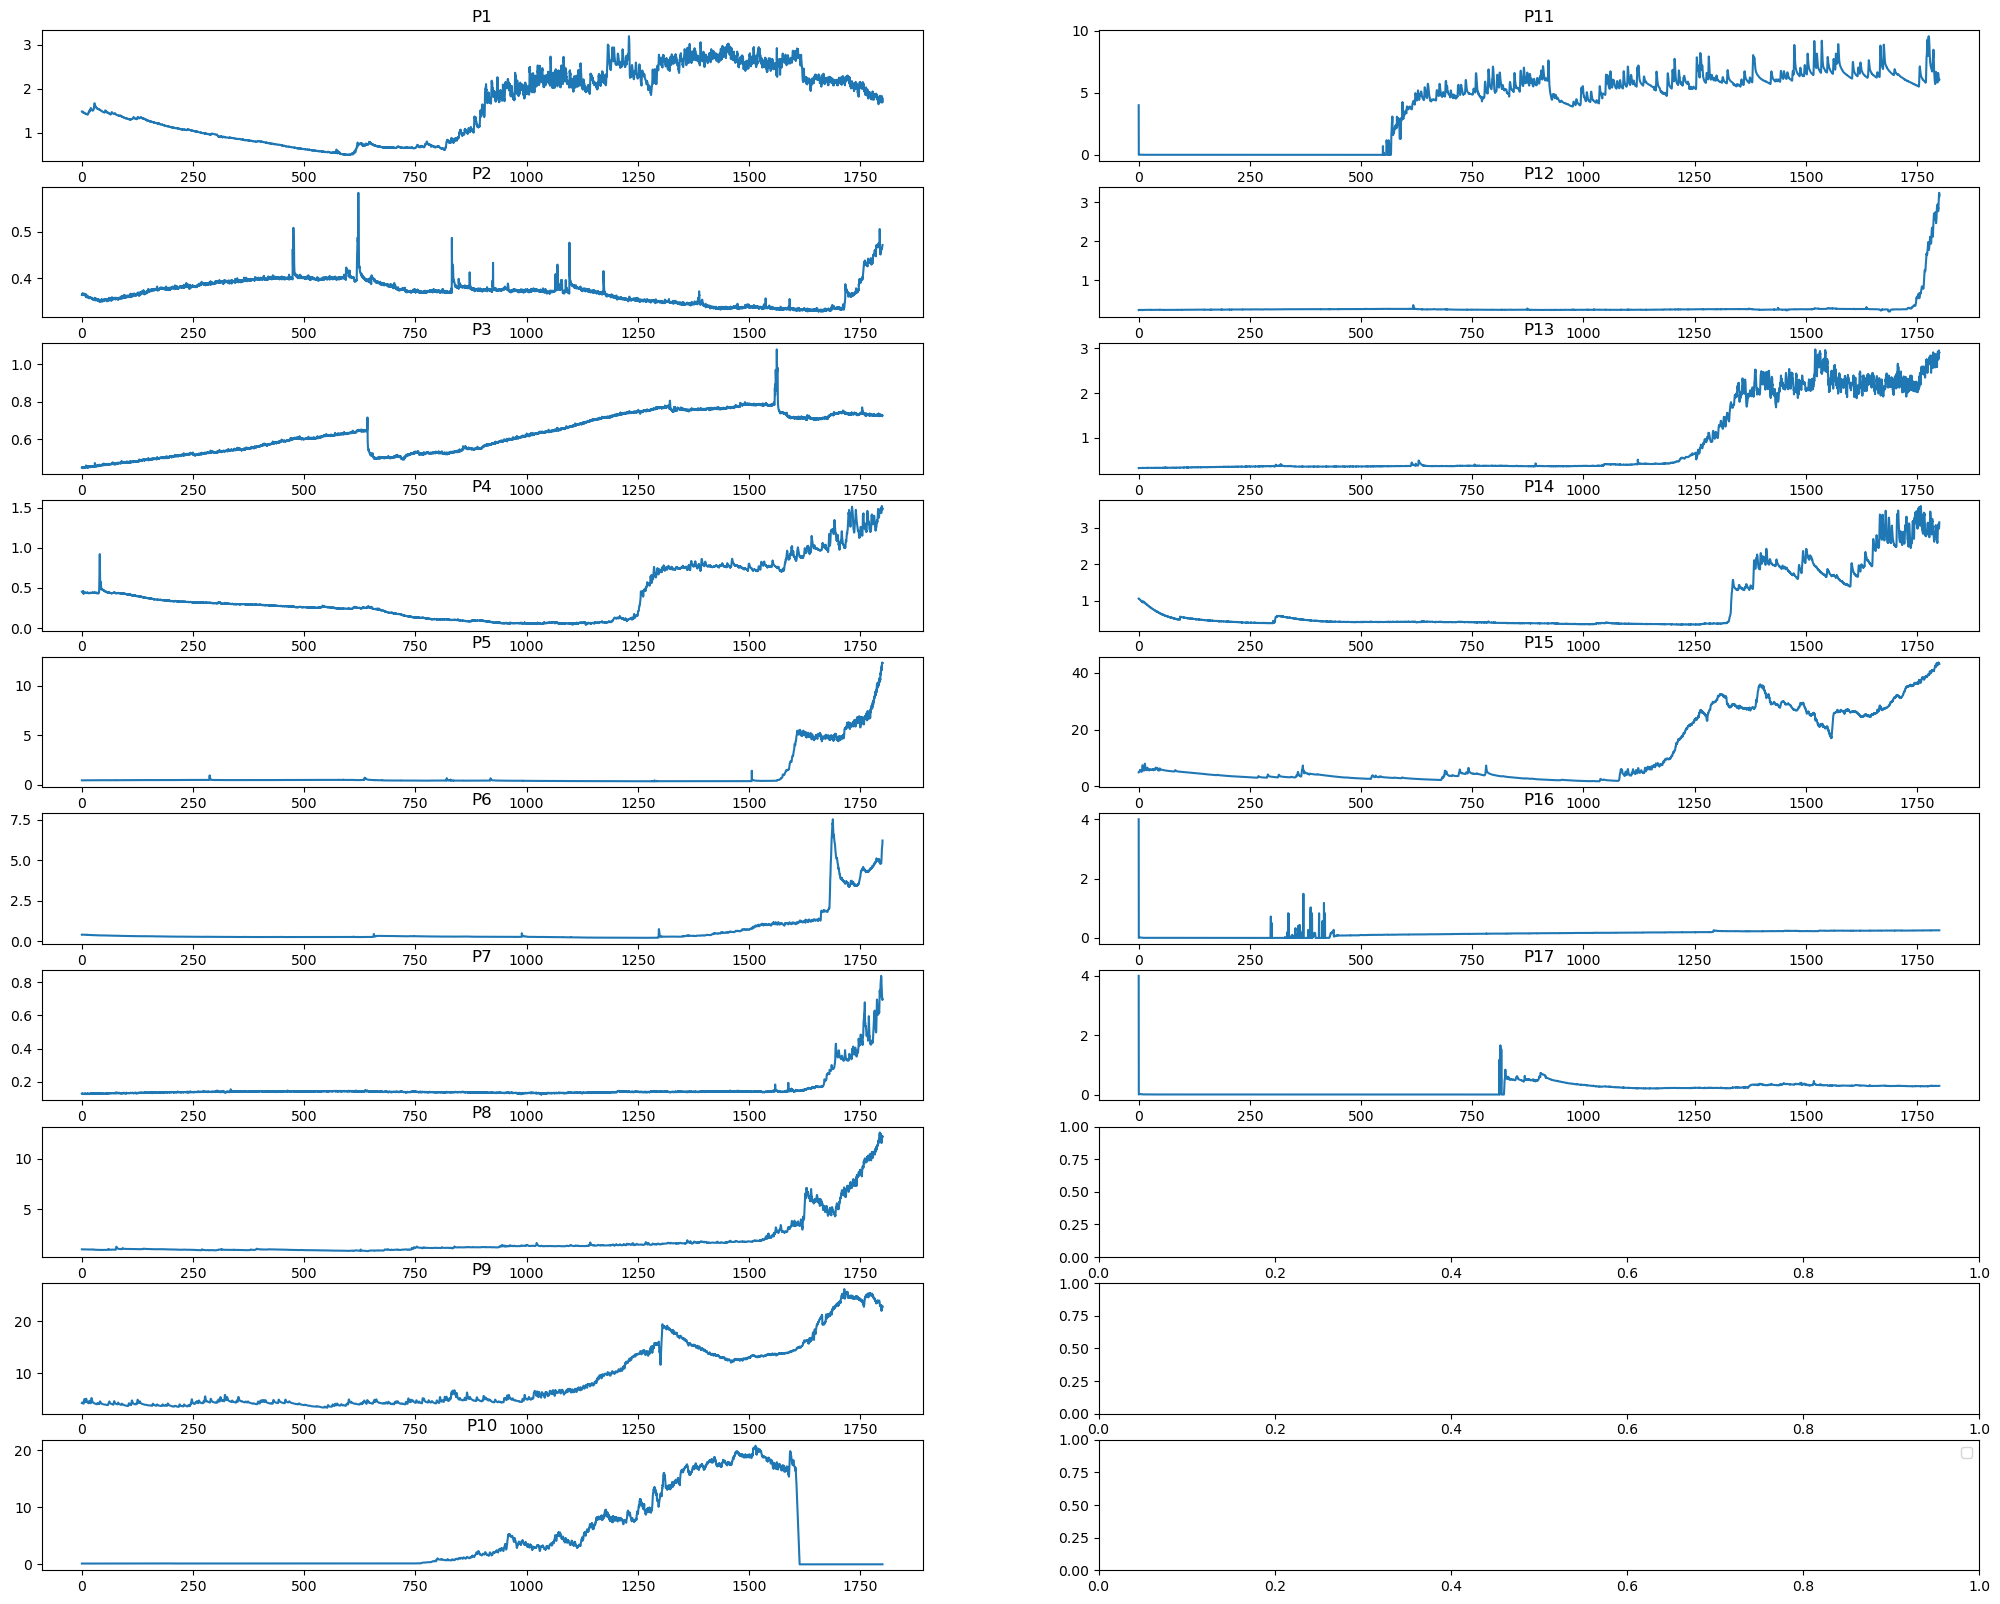

In [71]:
figure, axis = plt.subplots(10, 2) 
for i, eda_raw in enumerate(eda_all): # 7 and 14 prob
    total_sec = 1800
    sample_rate = 4
    start_index = time_i_all[i]
    end_index = start_index + (total_sec * sample_rate) #1800 * sample_rate) # 30 mins
    eda_signal = eda_raw.iloc[start_index:end_index, 0]
    # # eda_signal = nk.ecg_clean(eda_signal, sampling_rate=sample_rate, method='biosppy')
    # signals, info = nk.ecg_process(eda_signal, sampling_rate=sample_rate, method='neurokit') # (default): 0.5 Hz high-pass butterworth filter (order = 5), followed by powerline filtering (see signal_filter()). By default, powerline = 50

    # # Visualize
    # nk.ecg_plot(signals, info)
    # plt.plot(numpy.linspace(0, total_sec, total_sec * sample_rate), eda_signal)
    # axis[i if i < 10 else i - 10,0 if i < 10 else 1].plot(numpy.linspace(0, len(eda_signal) / 4, len(eda_signal)), eda_signal, label='original')
    axis[i if i < 10 else i - 10,0 if i < 10 else 1].plot(numpy.linspace(0, total_sec, total_sec * sample_rate), eda_signal, label='original')
    axis[i if i < 10 else i - 10,0 if i < 10 else 1].set_title('P' + str(i + 1))
    # axis[i].set_title('ecg ' + str(i))
plt.legend(loc='best')

## PPG

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


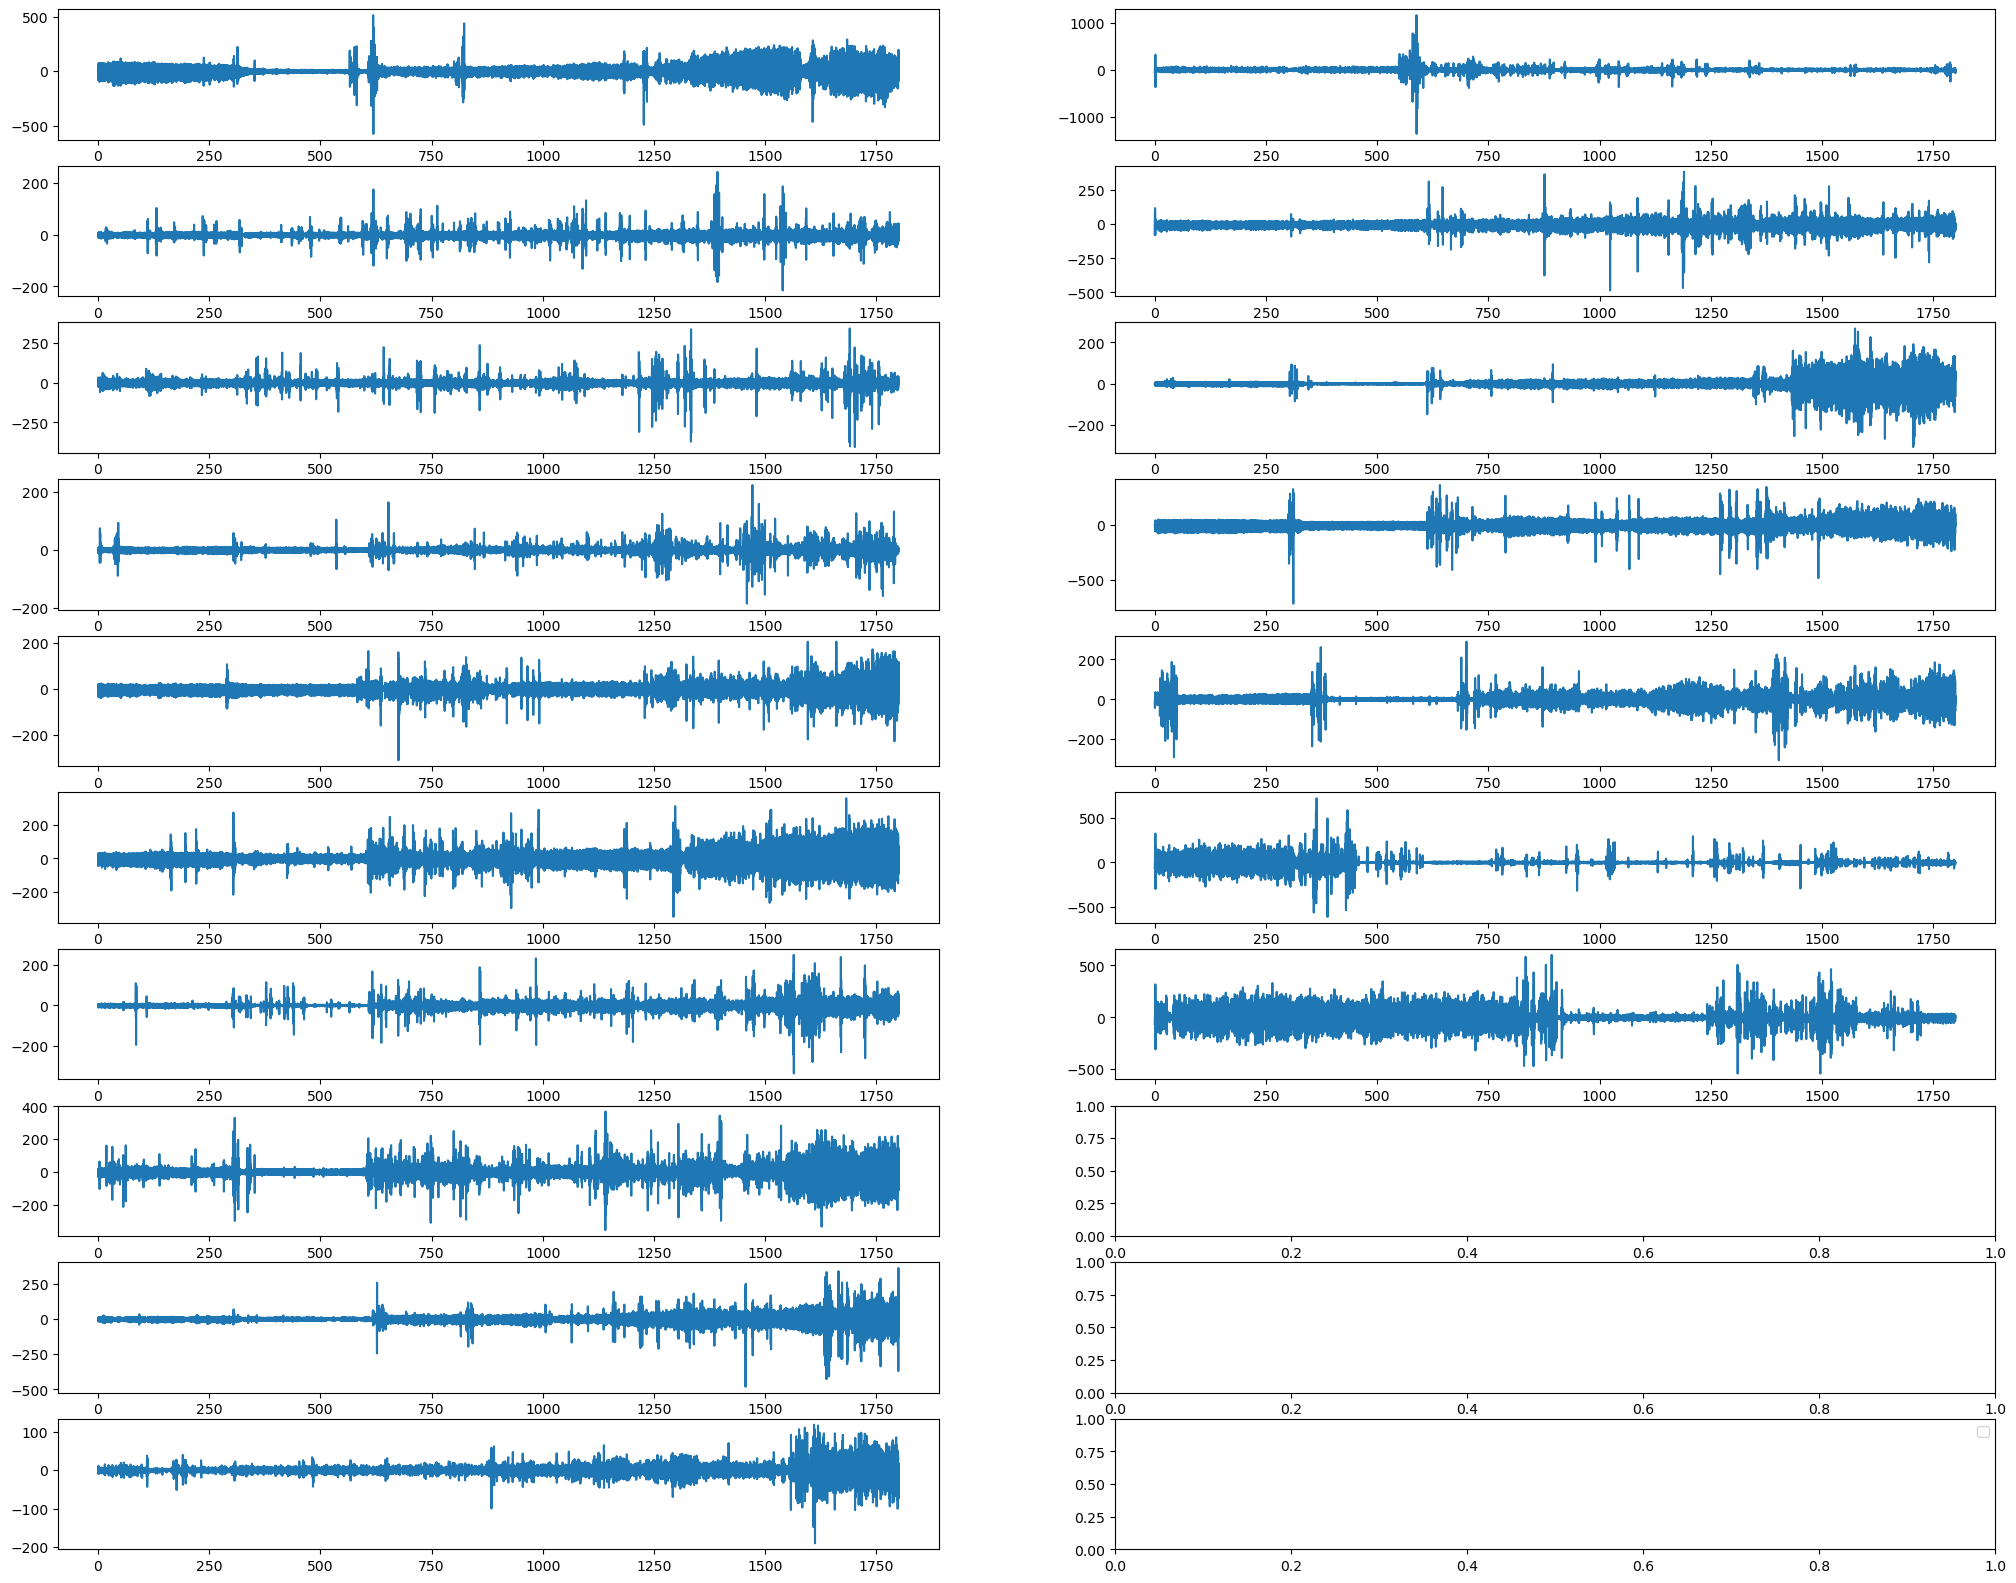

In [72]:
all_filtered_signals = []
lowcut = 0.7  # Lower cutoff frequency in Hz
highcut = 3.5  # Upper cutoff frequency in Hz
nyquist_freq = 250 / 2  # Nyquist frequency for 250 Hz sampling rate

# Calculate normalized cutoff frequencies
low = lowcut / nyquist_freq
high = highcut / nyquist_freq

order = 3  # Filter order
b, a = signal.butter(order, [low, high], btype='band')
figure, axis = plt.subplots(10, 2) 
for i, ppg_raw in enumerate(ppg_all): # 7 and 14 prob
    total_sec = 1800
    sample_rate = 64
    start_index = time_i_all_ppg[i]
    end_index = start_index + (total_sec * sample_rate) #1800 * sample_rate) # 30 mins
    ppg_signal = ppg_raw.iloc[start_index:end_index, 0]
    ppg_signal = ppg_signal.reset_index(drop=True)
    # # Visualize
    # Full signal
    # axis[i if i < 10 else i - 10,0 if i < 10 else 1].plot(numpy.linspace(0, len(ppg_signal) / 4, len(ppg_signal)), ppg_signal, label='original')

    filtered2 = signal.filtfilt(b, a, ppg_signal)   
    filtered3 = nk.ppg_clean(ppg_signal, sampling_rate=64, heart_rate=None, method='elgendi')
    df = pd.DataFrame() 
    df['ppg'] = filtered3
    moving_avg_ppg  = df['ppg'].rolling(window=640).mean(center=True).fillna(0)
    x_ppg.append(filtered3) 
    # 30 min signal
    axis[i if i < 10 else i - 10,0 if i < 10 else 1].plot(numpy.linspace(0, total_sec, total_sec * sample_rate), filtered3, label='original')

    # # Set title of each subplot
    # axis[i if i < 10 else i - 10,0 if i < 10 else 1].set_title('P' + str(i + 1))
    # axis[i].set_title('ecg ' + str(i))
plt.legend(loc='best')

## Acceleration Data 

In [73]:
acc_all[3]

,timestamp,ax,ay,az,gx,gy,gz
0,1637949711814,-10066,-5042,-11384,335,3,157
1,1637949711823,-10114,-5046,-11504,288,25,250
2,1637949711833,-10295,-5255,-11458,246,68,309
3,1637949711842,-10518,-5607,-11376,222,65,321
4,1637949711852,-10673,-5903,-11353,253,42,279
...,...,...,...,...,...,...,...
255969,1637952579912,13386,5795,2419,5114,-2153,2492
255970,1637952579922,13466,6400,2514,2161,-2629,2437
255971,1637952579931,13561,6708,2586,-1798,-3295,2702
255972,1637952579941,13665,6566,2666,-4757,-4206,3321


              ax         ay        az
0       0.000000   0.000000  0.000000
1       0.000000   0.000000  0.000000
2       0.000000   0.000000  0.000000
3       0.000000   0.000000  0.000000
4       0.000000   0.000000  0.000000
...          ...        ...       ...
179995  4.070102  14.028162  6.801894
179996  4.069370  14.032598  6.798400
179997  4.068605  14.036555  6.794910
179998  4.067842  14.039838  6.791521
179999  4.067012  14.042318  6.788259

[180000 rows x 3 columns]
              ax         ay        az
0       0.000000   0.000000  0.000000
1       0.000000   0.000000  0.000000
2       0.000000   0.000000  0.000000
3       0.000000   0.000000  0.000000
4       0.000000   0.000000  0.000000
...          ...        ...       ...
179995 -3.201696  15.699101 -1.939130
179996 -3.202018  15.699566 -1.940313
179997 -3.202376  15.700058 -1.941551
179998 -3.202765  15.700537 -1.942852
179999 -3.203222  15.701032 -1.944252

[180000 rows x 3 columns]
              ax         ay       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


              ax         ay        az
0       0.000000   0.000000  0.000000
1       0.000000   0.000000  0.000000
2       0.000000   0.000000  0.000000
3       0.000000   0.000000  0.000000
4       0.000000   0.000000  0.000000
...          ...        ...       ...
179995 -1.318165  15.667141 -2.393159
179996 -1.316996  15.666996 -2.388964
179997 -1.315849  15.666869 -2.384766
179998 -1.314712  15.666694 -2.380673
179999 -1.313554  15.666508 -2.376626

[180000 rows x 3 columns]
              ax         ay        az
0       0.000000   0.000000  0.000000
1       0.000000   0.000000  0.000000
2       0.000000   0.000000  0.000000
3       0.000000   0.000000  0.000000
4       0.000000   0.000000  0.000000
...          ...        ...       ...
179995 -8.657361  10.958337 -7.783263
179996 -8.654301  10.955418 -7.777028
179997 -8.651081  10.952099 -7.771624
179998 -8.647869  10.948380 -7.767253
179999 -8.644978  10.944462 -7.763820

[180000 rows x 3 columns]


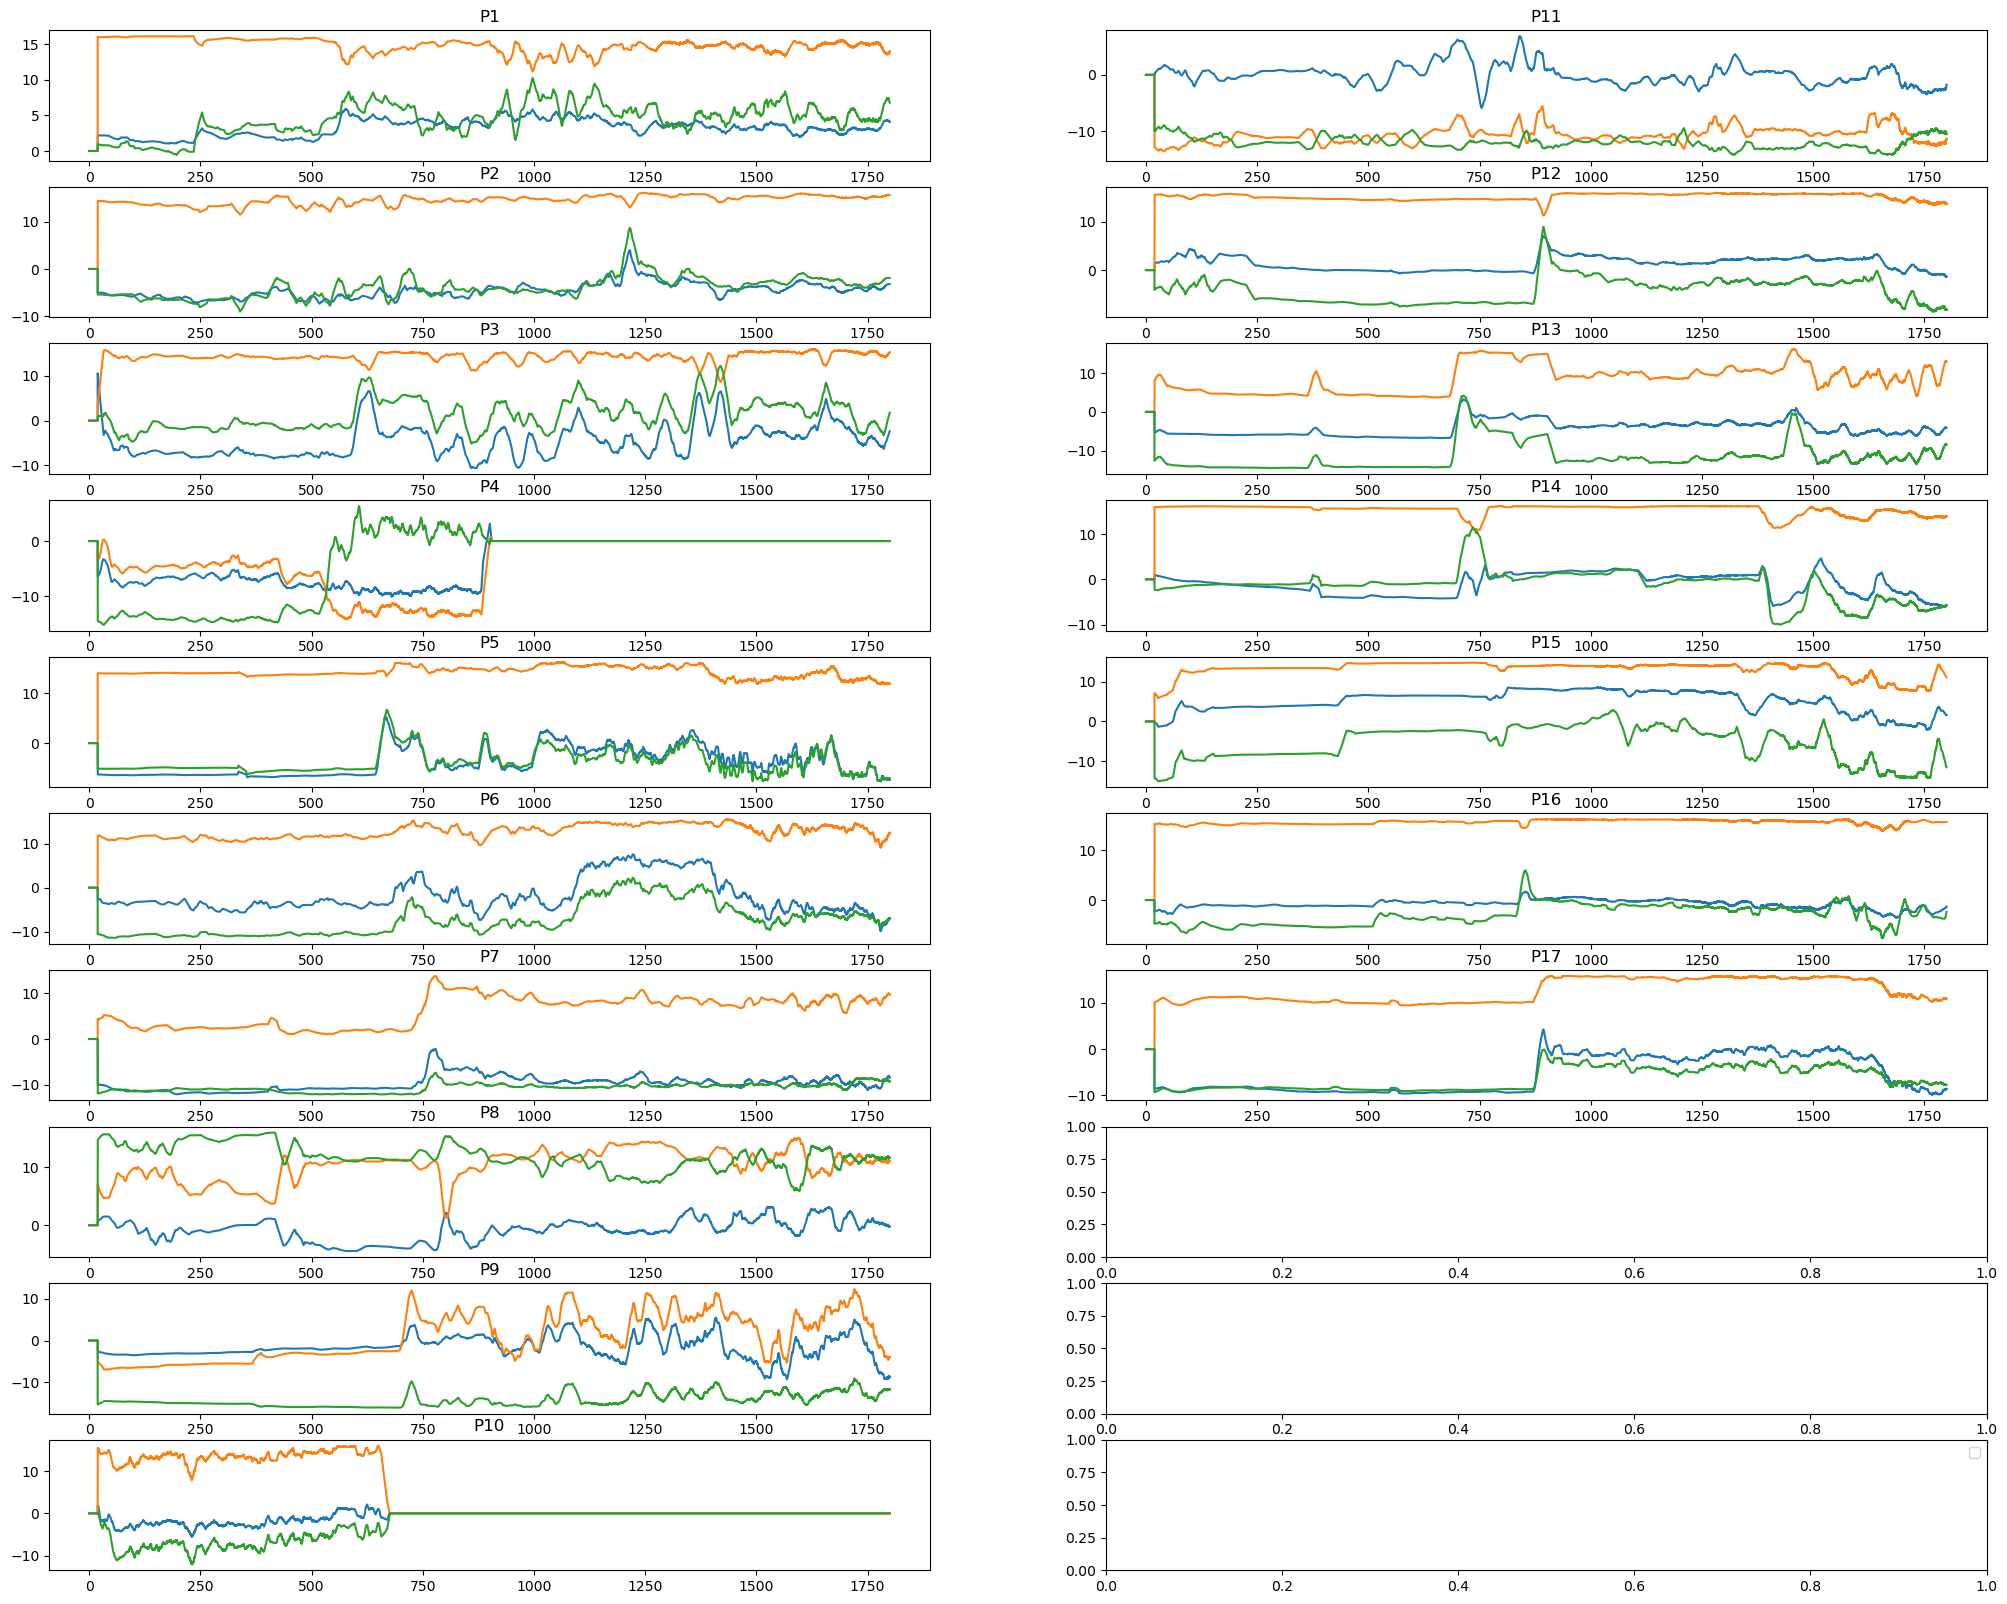

In [74]:
figure, axis = plt.subplots(10, 2) 
# figure2, axis2 = plt.subplots(10, 2) 
for i, acc_raw in enumerate(acc_all): # 7 and 14 prob
    # unit conversion
    acc_raw = acc_raw.iloc[:, 1:7].apply(lambda num: num / 1000)
    total_sec = 1800
    sample_rate = 100
    start_index = time_i_all_acc[i]
    end_index = start_index + (total_sec * sample_rate)
    # ============ Visualize ===============
    # Full signal 
    # acc_signal = acc_raw.iloc[:, 1:4]
    # axis[i if i < 10 else i - 10,0 if i < 10 else 1].plot(numpy.linspace(0, len(acc_signal) / sample_rate, len(acc_signal)), acc_signal, label='original')

    acc_signal = acc_raw.iloc[start_index:end_index, :]
    acc_signal = acc_signal.reset_index(drop=True)

    length_diff = total_sec * sample_rate - len(acc_signal)
    if length_diff > 0:
        acc_signal = acc_signal.reindex(index=range(start_index, start_index + total_sec * sample_rate), fill_value=0)
    # 30 min signal unfiltered 
    # axis[i if i < 10 else i - 10,0 if i < 10 else 1].plot(numpy.linspace(0, total_sec, total_sec * sample_rate), acc_signal, label='original')

    # Filtered 
    # acc_signal = acc_raw.iloc[start_index:end_index, 0:3]
    acc = acc_signal.iloc[:, 0:3]
    gyro = acc_signal.iloc[:, 3:6]
    moving_avg_acc = acc.rolling(window=32*60).mean(center=True).fillna(0)
    print(moving_avg_acc)

    x_acc.append(moving_avg_acc)
    axis[i if i < 10 else i - 10,0 if i < 10 else 1].plot(numpy.linspace(0, total_sec, total_sec * sample_rate), moving_avg_acc, label='acc')
    # Set title of each subplot
    axis[i if i < 10 else i - 10,0 if i < 10 else 1].set_title('P' + str(i + 1))

    moving_avg_gyro = gyro.rolling(window=32*60).mean(center=True).fillna(0)
    x_gyro.append(moving_avg_gyro)
    # axis2[i if i < 10 else i - 10,0 if i < 10 else 1].plot(numpy.linspace(0, total_sec, total_sec * sample_rate), moving_avg_gyro, label='gyro')
    # # Set title of each subplot
    # axis2[i if i < 10 else i - 10,0 if i < 10 else 1].set_title('P' + str(i + 1))
    # axis[i].set_title('ecg ' + str(i))
plt.legend(loc='best')

In [75]:
print(x_acc[0].iloc[5000:6000, 0])

5000    1.933116
5001    1.932818
5002    1.932525
5003    1.932235
5004    1.931930
          ...   
5995    1.697090
5996    1.696998
5997    1.696920
5998    1.696842
5999    1.696756
Name: ax, Length: 1000, dtype: float64


## Feature Extraction: Acc and Gyro

In [76]:
import pandas as pd
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters

# Assuming 'data' is your DataFrame with columns 'timestamp' and 'value'
# 'timestamp' should be in datetime format
# Define the time window size (6 seconds in this case)
time_window = pd.Timedelta(seconds=6)
total_sec = 1800

dataframe = pd.DataFrame()



start_t = range(0, 180000, 600)

acc_col = [[i] for i in x_acc]
gyro_col = [[i] for i in x_gyro]

X = pd.DataFrame()
X['window_start_times'] = start_t
# X['acc'] = x_acc[0][0]
# X['gyro'] = x_gyro[0][0]


# Set up a column for time window identifiers
# data['window_id'] = (data['timestamp'] - data['timestamp'].iloc[0]) // time_window

# Group data into 6-second time windows
# grouped = data.groupby('window_id')

# Initialize an empty DataFrame to store extracted features
extracted_features = pd.DataFrame()

# Define the extraction settings (features you want to extract)
# extraction_settings = ComprehensiveFCParameters()
# # extracted = []
# Iterate over each time window and extract features
for id in X['window_start_times']: 
    window = pd.DataFrame()
    window['id'] = [0] * 600
    window['acc'] = [float(i) for i in x_acc[0].iloc[id: id+600, 0]]
    window['gyro'] = [float(i) for i in x_gyro[0].iloc[id: id+600, 0]]
    extracted_part = extract_features(window, column_id='id', default_fc_parameters={ 
        "sum_values": None, 
        "median": None,  
        "mean": None, 
        "length": None, 
        "standard_deviation": None, 
        "variance": None, 
        "root_mean_square": None, 
        "maximum": None, 
        "absolute_maximum":None, 
        "minimum": None
    }) 
     
    extracted_features = pd.concat([extracted_features, extracted_part]) 
extracted_features.reset_index(drop=True, inplace=True) 
X = pd.concat([X, extracted_features], axis=1)


X


Feature Extraction: 100%|██████████| 2/2 [00:05<00:00,  2.93s/it]


,window_start_times,acc__sum_values,acc__median,acc__mean,acc__length,acc__standard_deviation,acc__variance,acc__root_mean_square,acc__maximum,acc__absolute_maximum,...,gyro__sum_values,gyro__median,gyro__mean,gyro__length,gyro__standard_deviation,gyro__variance,gyro__root_mean_square,gyro__maximum,gyro__absolute_maximum,gyro__minimum
0,0,0.000000,0.000000,0.000000,600.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,600.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,600,0.000000,0.000000,0.000000,600.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,600.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1200,0.000000,0.000000,0.000000,600.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,600.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1800,1061.047912,2.198928,1.768413,600.0,0.879644,0.773774,1.975110,2.218655,2.218655,...,4.318239,0.008291,0.007197,600.0,0.003730,0.000014,0.008106,0.010846,0.010846,0.000000
4,2400,1308.581503,2.181567,2.180969,600.0,0.003513,0.000012,2.180972,2.189022,2.189022,...,4.561883,0.007338,0.007603,600.0,0.001187,0.000001,0.007695,0.010443,0.010443,0.005541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,177000,1768.756525,2.937583,2.947928,600.0,0.096980,0.009405,2.949522,3.160858,3.160858,...,-6.953594,-0.015282,-0.011589,600.0,0.049971,0.002497,0.051297,0.065824,0.083838,-0.083838
296,177600,1959.035713,3.212791,3.265060,600.0,0.138559,0.019199,3.267998,3.555424,3.555424,...,-19.371607,-0.051294,-0.032286,600.0,0.048451,0.002348,0.058223,0.081976,0.086948,-0.086948
297,178200,2360.738826,3.925724,3.934565,600.0,0.233466,0.054507,3.941485,4.255065,4.255065,...,-32.680758,-0.064144,-0.054468,600.0,0.023155,0.000536,0.059185,-0.003729,0.085083,-0.085083
298,178800,2562.717349,4.270508,4.271196,600.0,0.043357,0.001880,4.271416,4.362194,4.362194,...,-12.921045,-0.021609,-0.021535,600.0,0.021877,0.000479,0.030698,0.017961,0.064894,-0.064894


In [77]:
# X['window_start_times'] = X.iloc[:, 0].apply(lambda x: x / 100) 
X

,window_start_times,acc__sum_values,acc__median,acc__mean,acc__length,acc__standard_deviation,acc__variance,acc__root_mean_square,acc__maximum,acc__absolute_maximum,...,gyro__sum_values,gyro__median,gyro__mean,gyro__length,gyro__standard_deviation,gyro__variance,gyro__root_mean_square,gyro__maximum,gyro__absolute_maximum,gyro__minimum
0,0,0.000000,0.000000,0.000000,600.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,600.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,600,0.000000,0.000000,0.000000,600.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,600.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1200,0.000000,0.000000,0.000000,600.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,600.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1800,1061.047912,2.198928,1.768413,600.0,0.879644,0.773774,1.975110,2.218655,2.218655,...,4.318239,0.008291,0.007197,600.0,0.003730,0.000014,0.008106,0.010846,0.010846,0.000000
4,2400,1308.581503,2.181567,2.180969,600.0,0.003513,0.000012,2.180972,2.189022,2.189022,...,4.561883,0.007338,0.007603,600.0,0.001187,0.000001,0.007695,0.010443,0.010443,0.005541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,177000,1768.756525,2.937583,2.947928,600.0,0.096980,0.009405,2.949522,3.160858,3.160858,...,-6.953594,-0.015282,-0.011589,600.0,0.049971,0.002497,0.051297,0.065824,0.083838,-0.083838
296,177600,1959.035713,3.212791,3.265060,600.0,0.138559,0.019199,3.267998,3.555424,3.555424,...,-19.371607,-0.051294,-0.032286,600.0,0.048451,0.002348,0.058223,0.081976,0.086948,-0.086948
297,178200,2360.738826,3.925724,3.934565,600.0,0.233466,0.054507,3.941485,4.255065,4.255065,...,-32.680758,-0.064144,-0.054468,600.0,0.023155,0.000536,0.059185,-0.003729,0.085083,-0.085083
298,178800,2562.717349,4.270508,4.271196,600.0,0.043357,0.001880,4.271416,4.362194,4.362194,...,-12.921045,-0.021609,-0.021535,600.0,0.021877,0.000479,0.030698,0.017961,0.064894,-0.064894


## PPG

In [78]:
import heartpy as hp 
start_ts = range(0, 1800 * 64, 6 * 64)  
 
# Initialize an empty DataFrame to store extracted features
extracted_features = pd.DataFrame()

# Define the extraction settings (features you want to extract)
# extraction_settings = ComprehensiveFCParameters()
# # extracted = []
# Iterate over each time window and extract features 
for start_t in start_ts:  
    print(f"now is {start_t / 64}")
    _, measures = hp.process(x_ppg[0][start_t: start_t + 6 * 64], sample_rate=64) 
    measures = {k:[v] for k,v in measures.items()} 
    extracted_part = pd.DataFrame.from_dict(measures) 
    extracted_features = pd.concat([extracted_features, extracted_part]) 
extracted_features.reset_index(drop=True, inplace=True) 
X = pd.concat([X, extracted_features], axis=1)  

# _, measures = hp.process_segmentwise(x_ppg[0], sample_rate=64, segment_width=6) 
# # measures = {k:[v] for k,v in measures.items()} 
# extracted_part = pd.DataFrame.from_dict(measures) 
# extracted_features = pd.concat([extracted_features, extracted_part]) 


X

now is 0.0
now is 6.0
now is 12.0
now is 18.0
now is 24.0
now is 30.0
now is 36.0
now is 42.0
now is 48.0
now is 54.0
now is 60.0
now is 66.0
now is 72.0
now is 78.0
now is 84.0
now is 90.0
now is 96.0
now is 102.0
now is 108.0
now is 114.0
now is 120.0
now is 126.0
now is 132.0
now is 138.0
now is 144.0
now is 150.0
now is 156.0
now is 162.0
now is 168.0
now is 174.0
now is 180.0
now is 186.0
now is 192.0
now is 198.0
now is 204.0
now is 210.0
now is 216.0
now is 222.0
now is 228.0
now is 234.0
now is 240.0
now is 246.0
now is 252.0
now is 258.0
now is 264.0
now is 270.0
now is 276.0
now is 282.0
now is 288.0
now is 294.0
now is 300.0
now is 306.0
now is 312.0
now is 318.0
now is 324.0
now is 330.0
now is 336.0
now is 342.0
now is 348.0
now is 354.0
now is 360.0
now is 366.0


c:\Users\abrar\anaconda3\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\abrar\anaconda3\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\abrar\anaconda3\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing

now is 372.0
now is 378.0
now is 384.0
now is 390.0
now is 396.0
now is 402.0
now is 408.0
now is 414.0
now is 420.0
now is 426.0
now is 432.0
now is 438.0
now is 444.0
now is 450.0
now is 456.0
now is 462.0
now is 468.0
now is 474.0
now is 480.0
now is 486.0
now is 492.0
now is 498.0
now is 504.0
now is 510.0
now is 516.0
now is 522.0
now is 528.0
now is 534.0
now is 540.0
now is 546.0
now is 552.0
now is 558.0
now is 564.0
now is 570.0
now is 576.0
now is 582.0
now is 588.0
now is 594.0
now is 600.0
now is 606.0
now is 612.0
now is 618.0
now is 624.0
now is 630.0
now is 636.0
now is 642.0
now is 648.0
now is 654.0
now is 660.0
now is 666.0
now is 672.0
now is 678.0
now is 684.0
now is 690.0
now is 696.0
now is 702.0
now is 708.0
now is 714.0


c:\Users\abrar\anaconda3\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\abrar\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\abrar\anaconda3\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\abrar\anaconda3\lib\site-packages\numpy\ma\core.py:5317: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
c:\Users\abrar\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarn

now is 720.0
now is 726.0
now is 732.0
now is 738.0
now is 744.0
now is 750.0
now is 756.0
now is 762.0
now is 768.0
now is 774.0
now is 780.0
now is 786.0
now is 792.0
now is 798.0
now is 804.0
now is 810.0
now is 816.0
now is 822.0
now is 828.0
now is 834.0
now is 840.0
now is 846.0
now is 852.0
now is 858.0
now is 864.0
now is 870.0
now is 876.0
now is 882.0


c:\Users\abrar\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\abrar\anaconda3\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\abrar\anaconda3\lib\site-packages\numpy\ma\core.py:5317: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
c:\Users\abrar\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\abrar\anaconda3\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding 

now is 888.0
now is 894.0
now is 900.0
now is 906.0
now is 912.0
now is 918.0
now is 924.0
now is 930.0
now is 936.0
now is 942.0
now is 948.0
now is 954.0
now is 960.0
now is 966.0
now is 972.0
now is 978.0
now is 984.0
now is 990.0
now is 996.0
now is 1002.0
now is 1008.0
now is 1014.0
now is 1020.0
now is 1026.0
now is 1032.0
now is 1038.0


c:\Users\abrar\anaconda3\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


now is 1044.0
now is 1050.0
now is 1056.0
now is 1062.0
now is 1068.0
now is 1074.0
now is 1080.0
now is 1086.0
now is 1092.0
now is 1098.0
now is 1104.0
now is 1110.0
now is 1116.0
now is 1122.0
now is 1128.0
now is 1134.0
now is 1140.0
now is 1146.0
now is 1152.0
now is 1158.0
now is 1164.0
now is 1170.0
now is 1176.0
now is 1182.0
now is 1188.0
now is 1194.0


c:\Users\abrar\anaconda3\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\abrar\anaconda3\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\abrar\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\abrar\anaconda3\li

now is 1200.0
now is 1206.0
now is 1212.0
now is 1218.0
now is 1224.0
now is 1230.0
now is 1236.0
now is 1242.0
now is 1248.0
now is 1254.0
now is 1260.0
now is 1266.0
now is 1272.0
now is 1278.0
now is 1284.0
now is 1290.0
now is 1296.0
now is 1302.0
now is 1308.0
now is 1314.0
now is 1320.0
now is 1326.0
now is 1332.0
now is 1338.0
now is 1344.0
now is 1350.0


c:\Users\abrar\anaconda3\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\abrar\anaconda3\lib\site-packages\numpy\ma\core.py:5317: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
c:\Users\abrar\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\abrar\anaconda3\lib\site-packages\numpy\ma\core.py:5317: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
c:\Users\abrar\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3

now is 1356.0
now is 1362.0
now is 1368.0
now is 1374.0
now is 1380.0
now is 1386.0
now is 1392.0
now is 1398.0
now is 1404.0
now is 1410.0
now is 1416.0
now is 1422.0
now is 1428.0
now is 1434.0
now is 1440.0
now is 1446.0
now is 1452.0
now is 1458.0
now is 1464.0
now is 1470.0
now is 1476.0
now is 1482.0
now is 1488.0
now is 1494.0
now is 1500.0
now is 1506.0
now is 1512.0
now is 1518.0
now is 1524.0
now is 1530.0
now is 1536.0
now is 1542.0
now is 1548.0
now is 1554.0
now is 1560.0
now is 1566.0
now is 1572.0
now is 1578.0
now is 1584.0
now is 1590.0
now is 1596.0
now is 1602.0
now is 1608.0
now is 1614.0
now is 1620.0
now is 1626.0
now is 1632.0
now is 1638.0
now is 1644.0
now is 1650.0
now is 1656.0
now is 1662.0
now is 1668.0
now is 1674.0
now is 1680.0
now is 1686.0
now is 1692.0


c:\Users\abrar\anaconda3\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\abrar\anaconda3\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


now is 1698.0
now is 1704.0
now is 1710.0
now is 1716.0
now is 1722.0
now is 1728.0
now is 1734.0
now is 1740.0
now is 1746.0
now is 1752.0
now is 1758.0
now is 1764.0
now is 1770.0
now is 1776.0
now is 1782.0
now is 1788.0
now is 1794.0


c:\Users\abrar\anaconda3\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


,window_start_times,acc__sum_values,acc__median,acc__mean,acc__length,acc__standard_deviation,acc__variance,acc__root_mean_square,acc__maximum,acc__absolute_maximum,...,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate
0,0,0.000000,0.000000,0.000000,600.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.982446,20.457927,0.285714,0.000000,7.8125,14.465939,22.097087,1004.226154,0.654654,0.200080
1,600,0.000000,0.000000,0.000000,600.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,13.015518,22.097087,0.428571,0.000000,23.4375,15.302800,22.432758,1078.458557,0.682163,0.192345
2,1200,0.000000,0.000000,0.000000,600.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.366858,19.918045,0.250000,0.000000,15.6250,14.016309,16.970847,747.286336,0.825905,0.175932
3,1800,1061.047912,2.198928,1.768413,600.0,0.879644,0.773774,1.975110,2.218655,2.218655,...,8.351914,17.717085,0.142857,0.000000,15.6250,12.428045,19.071437,744.622443,0.651658,0.200080
4,2400,1308.581503,2.181567,2.180969,600.0,0.003513,0.000012,2.180972,2.189022,2.189022,...,11.38174,25.055741,0.285714,0.000000,15.6250,16.554014,25.352269,1318.469369,0.652960,0.197668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,177000,1768.756525,2.937583,2.947928,600.0,0.096980,0.009405,2.949522,3.160858,3.160858,...,37.648001,75.205881,0.833333,0.583333,31.2500,52.375483,35.035479,5764.822959,1.494927,0.180995
296,177600,1959.035713,3.212791,3.265060,600.0,0.138559,0.019199,3.267998,3.555424,3.555424,...,59.839194,120.130860,0.888889,0.777778,62.5000,82.020915,99.247263,25573.668123,0.826430,0.367040
297,178200,2360.738826,3.925724,3.934565,600.0,0.233466,0.054507,3.941485,4.255065,4.255065,...,82.956096,140.407818,0.750000,0.625000,46.8750,99.244891,93.423912,29128.363107,1.062307,0.182482
298,178800,2562.717349,4.270508,4.271196,600.0,0.043357,0.001880,4.271416,4.362194,4.362194,...,45.848127,86.574345,0.800000,0.600000,109.3750,57.505519,133.413164,24102.277733,0.431033,0.180440


In [79]:
X

,window_start_times,acc__sum_values,acc__median,acc__mean,acc__length,acc__standard_deviation,acc__variance,acc__root_mean_square,acc__maximum,acc__absolute_maximum,...,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate
0,0,0.000000,0.000000,0.000000,600.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.982446,20.457927,0.285714,0.000000,7.8125,14.465939,22.097087,1004.226154,0.654654,0.200080
1,600,0.000000,0.000000,0.000000,600.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,13.015518,22.097087,0.428571,0.000000,23.4375,15.302800,22.432758,1078.458557,0.682163,0.192345
2,1200,0.000000,0.000000,0.000000,600.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.366858,19.918045,0.250000,0.000000,15.6250,14.016309,16.970847,747.286336,0.825905,0.175932
3,1800,1061.047912,2.198928,1.768413,600.0,0.879644,0.773774,1.975110,2.218655,2.218655,...,8.351914,17.717085,0.142857,0.000000,15.6250,12.428045,19.071437,744.622443,0.651658,0.200080
4,2400,1308.581503,2.181567,2.180969,600.0,0.003513,0.000012,2.180972,2.189022,2.189022,...,11.38174,25.055741,0.285714,0.000000,15.6250,16.554014,25.352269,1318.469369,0.652960,0.197668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,177000,1768.756525,2.937583,2.947928,600.0,0.096980,0.009405,2.949522,3.160858,3.160858,...,37.648001,75.205881,0.833333,0.583333,31.2500,52.375483,35.035479,5764.822959,1.494927,0.180995
296,177600,1959.035713,3.212791,3.265060,600.0,0.138559,0.019199,3.267998,3.555424,3.555424,...,59.839194,120.130860,0.888889,0.777778,62.5000,82.020915,99.247263,25573.668123,0.826430,0.367040
297,178200,2360.738826,3.925724,3.934565,600.0,0.233466,0.054507,3.941485,4.255065,4.255065,...,82.956096,140.407818,0.750000,0.625000,46.8750,99.244891,93.423912,29128.363107,1.062307,0.182482
298,178800,2562.717349,4.270508,4.271196,600.0,0.043357,0.001880,4.271416,4.362194,4.362194,...,45.848127,86.574345,0.800000,0.600000,109.3750,57.505519,133.413164,24102.277733,0.431033,0.180440


## MET from vo2

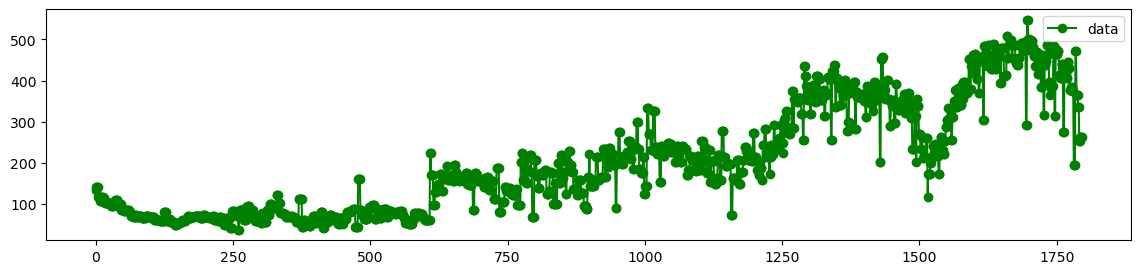

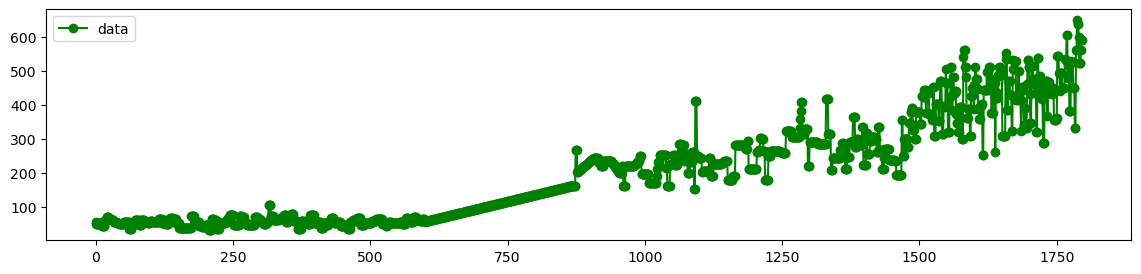

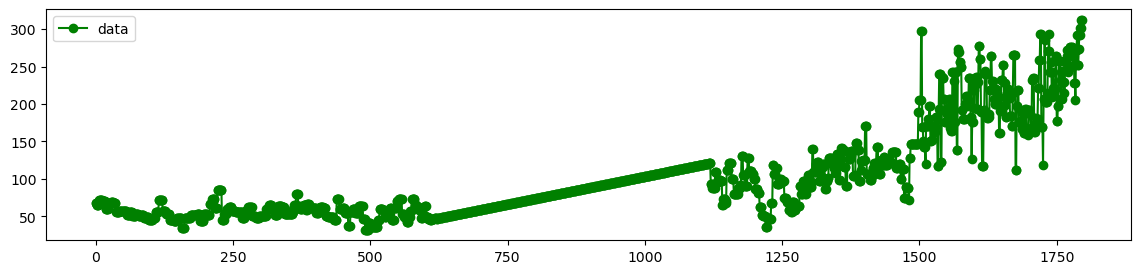

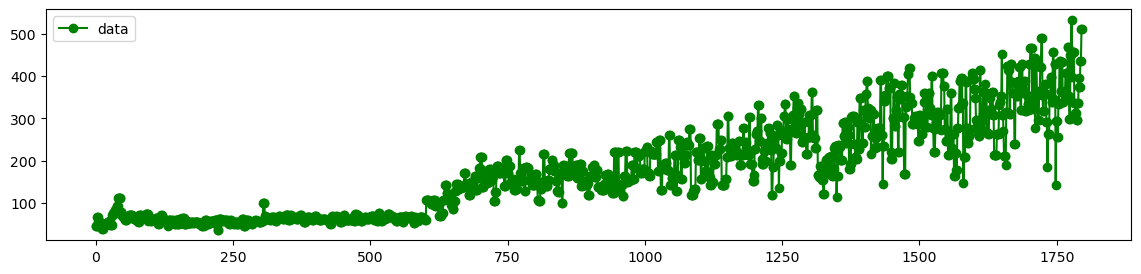

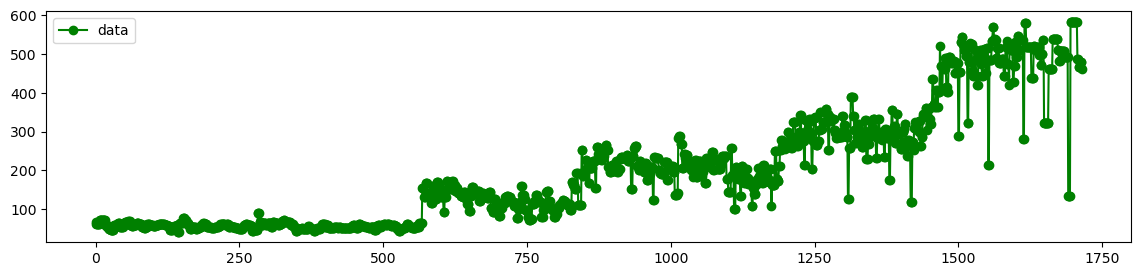

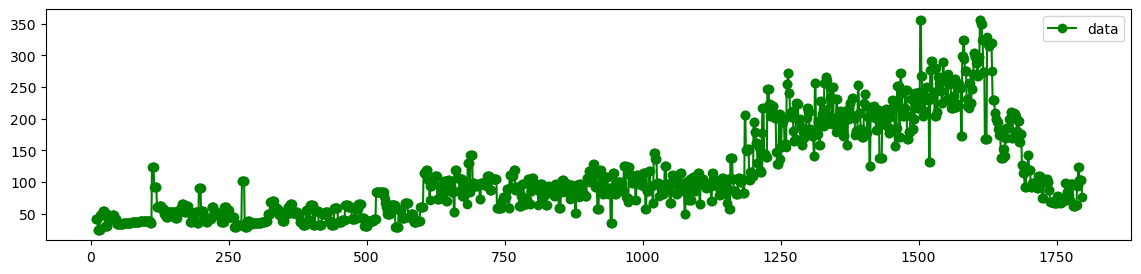

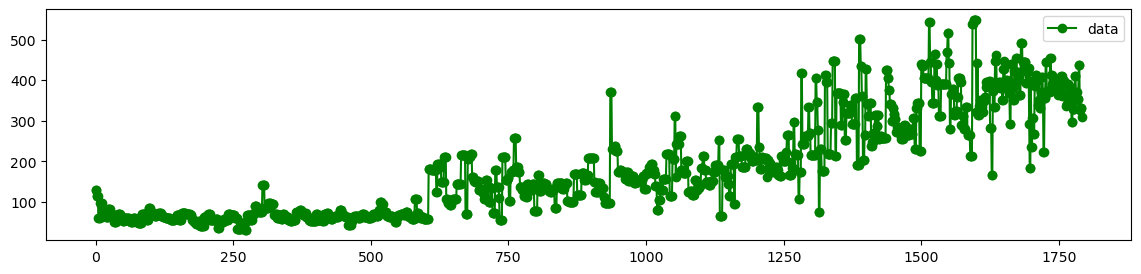

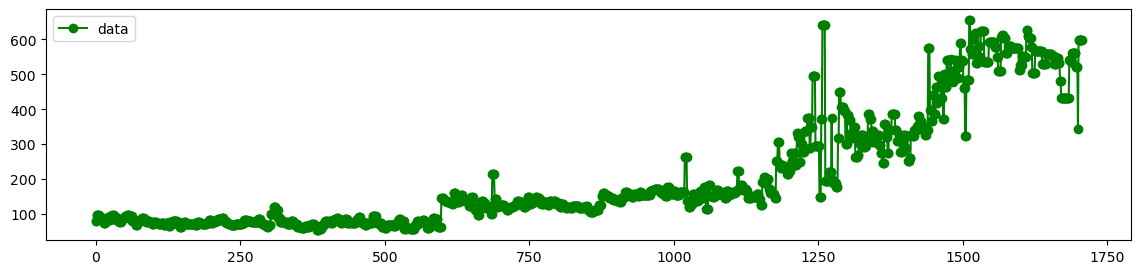

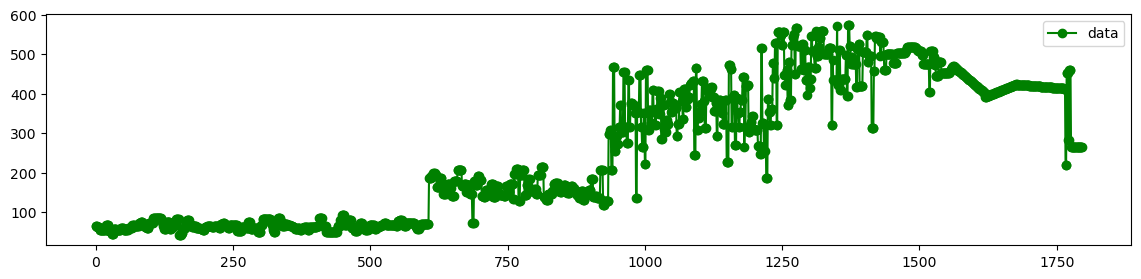

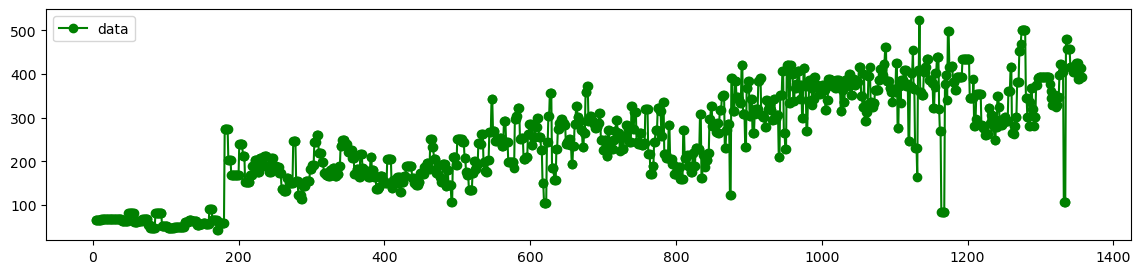

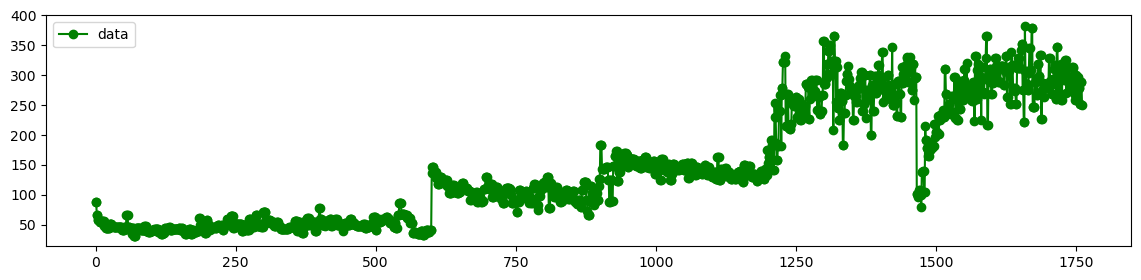

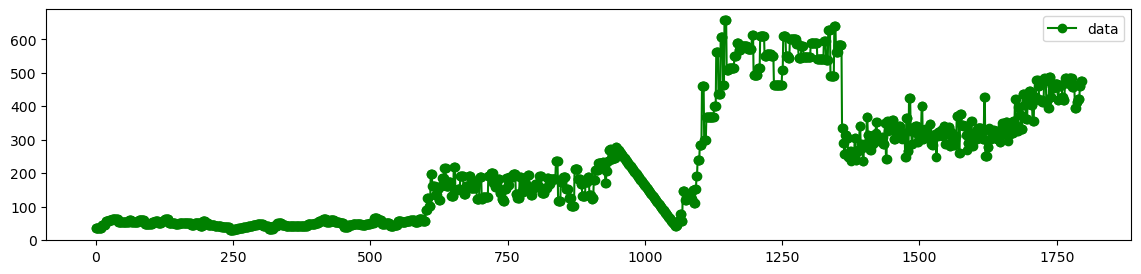

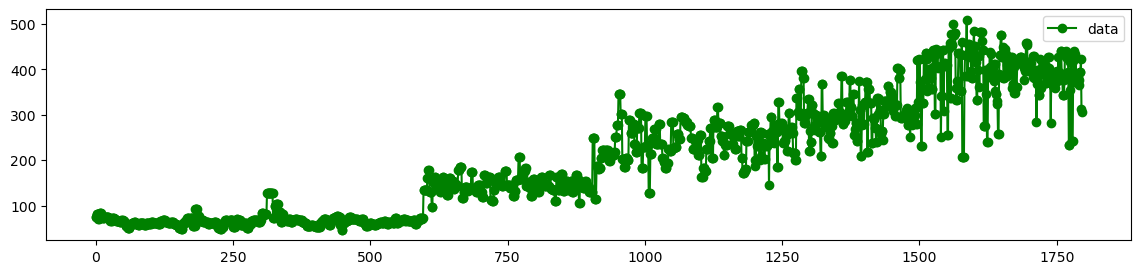

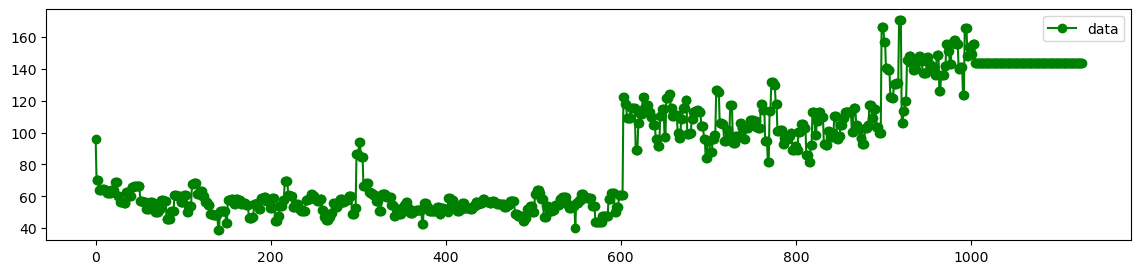

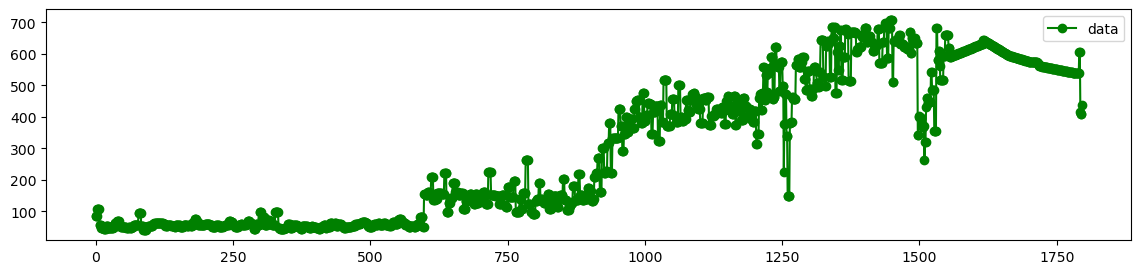

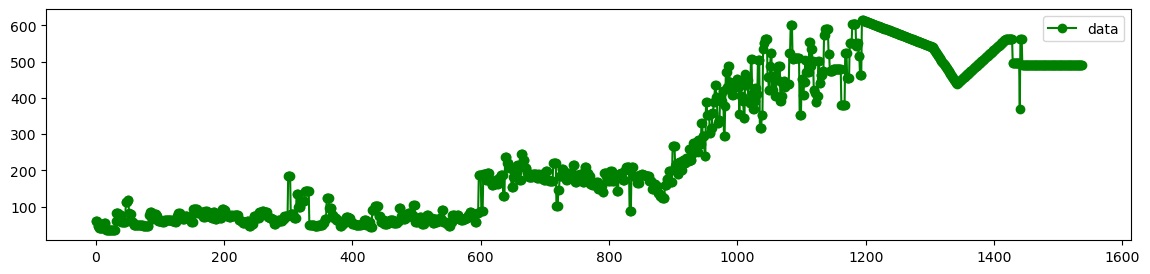

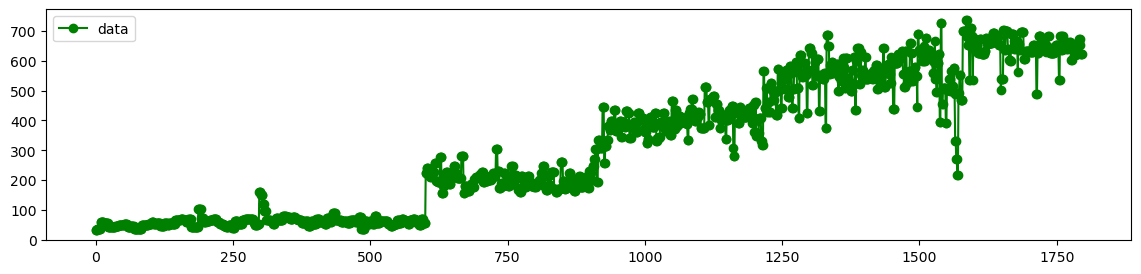

In [64]:
path = "./dataset/P*/VO2/DataAverage.csv"
vo2_all_raw = []
vo2_all = []
for filename in glob.glob(path):
    vo2_all_raw.append(pd.read_csv(filename))

from scipy import signal, interpolate as ip
import numpy as np
from utils import *


plt.rcParams["figure.figsize"] = (14,3)


for i, vo2full in enumerate(vo2_all_raw):
    vo2 = vo2full['VO2[mL/min]'].apply(lambda num: num / 3.5)

    vo2.replace(0, np.nan, inplace=True)  
    # vo2 = signal.resample(vo2, 250 * 1800)
    vo2 = vo2.interpolate()   
    vo2 = vo2[3:1800].reset_index(drop=True) 
    vo2_all.append(vo2) 
    # continue
    # print(vo2)
    # if i > 5:
    #     print(vo2)
    #     continue
    plt.plot(numpy.linspace(0, len(vo2), len(vo2),endpoint=False), vo2,'go-', label='data')
    plt.legend(loc='best')
    plt.show()

In [41]:
vo2_all[0]

0       134.334286
1       134.334286
2       140.380000
3       140.380000
4       140.380000
           ...    
1793    253.665714
1794    262.951429
1795    262.951429
1796    262.951429
1797    262.951429
Name: VO2[mL/min], Length: 1798, dtype: float64

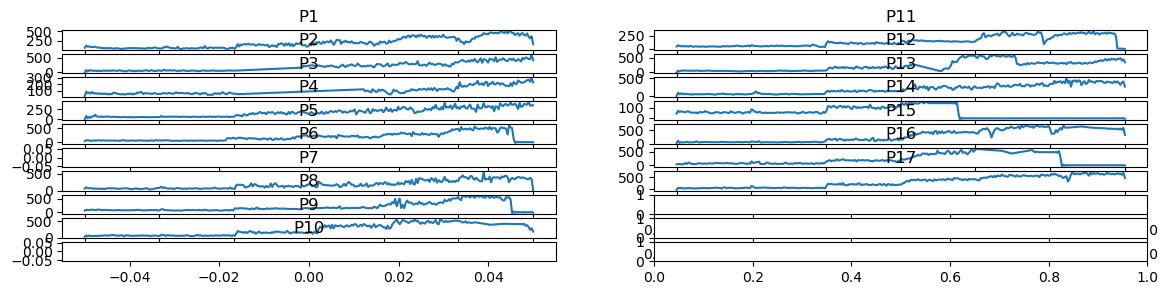

In [65]:
from scipy import signal  
vo2_resampled = []
figure, axis = plt.subplots(10, 2) 
for i, vo2 in enumerate(vo2_all):
    exp = vo2.reindex(range(1801), fill_value=0)
    ressed = signal.resample(exp, int(1800 / 6))
    vo2_resampled.append(ressed)
    # plt.plot(numpy.linspace(0, len(ressed), int(1800 / 6)), ressed,'go-', label='data')
    axis[i if i < 10 else i - 10,0 if i < 10 else 1].plot(numpy.linspace(0, 300, 300), ressed, label='original')

    # # Set title of each subplot
    axis[i if i < 10 else i - 10,0 if i < 10 else 1].set_title('P' + str(i + 1))
    # axis[i].set_title('ecg ' + str(i))

In [84]:
# create the training table

import pandas as pd
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters

# Assuming 'data' is your DataFrame with columns 'timestamp' and 'value'
# 'timestamp' should be in datetime format
# Define the time window size (6 seconds in this case)
time_window = pd.Timedelta(seconds=6)
total_sec = 1800

dataframe = pd.DataFrame()



start_t = list(range(0, 180000, 600))
print(start_t)

acc_col = [[i] for i in x_acc]
gyro_col = [[i] for i in x_gyro]

ids = []

for i in range(17):
    ids.extend([i] * 300)

X = pd.DataFrame()

X['PID'] = ids
X['window_start_times'] = start_t * len(vo2_all)
# X['acc'] = x_acc[0][0]
# X['gyro'] = x_gyro[0][0]


# Set up a column for time window identifiers
# data['window_id'] = (data['timestamp'] - data['timestamp'].iloc[0]) // time_window

# Group data into 6-second time windows
# grouped = data.groupby('window_id')

# Initialize an empty DataFrame to store extracted features
extracted_features = pd.DataFrame()

# Define the extraction settings (features you want to extract)
# extraction_settings = ComprehensiveFCParameters()
# # extracted = []
# Iterate over each time window and extract features
for id in X['window_start_times']: 
    window = pd.DataFrame()
    window['id'] = [0] * 600
    window['acc'] = [float(i) for i in x_acc[0].iloc[id: id+600, 0]]
    window['gyro'] = [float(i) for i in x_gyro[0].iloc[id: id+600, 0]]
    extracted_part = extract_features(window, column_id='id', default_fc_parameters={ 
        "sum_values": None, 
        "median": None,  
        "mean": None, 
        "length": None, 
        "standard_deviation": None, 
        "variance": None, 
        "root_mean_square": None, 
        "maximum": None, 
        "absolute_maximum":None, 
        "minimum": None
    }) 
     
    extracted_features = pd.concat([extracted_features, extracted_part]) 
extracted_features.reset_index(drop=True, inplace=True) 
X = pd.concat([X, extracted_features], axis=1)
pd.set_option('display.max_rows', 300 * 17)

X


[0, 600, 1200, 1800, 2400, 3000, 3600, 4200, 4800, 5400, 6000, 6600, 7200, 7800, 8400, 9000, 9600, 10200, 10800, 11400, 12000, 12600, 13200, 13800, 14400, 15000, 15600, 16200, 16800, 17400, 18000, 18600, 19200, 19800, 20400, 21000, 21600, 22200, 22800, 23400, 24000, 24600, 25200, 25800, 26400, 27000, 27600, 28200, 28800, 29400, 30000, 30600, 31200, 31800, 32400, 33000, 33600, 34200, 34800, 35400, 36000, 36600, 37200, 37800, 38400, 39000, 39600, 40200, 40800, 41400, 42000, 42600, 43200, 43800, 44400, 45000, 45600, 46200, 46800, 47400, 48000, 48600, 49200, 49800, 50400, 51000, 51600, 52200, 52800, 53400, 54000, 54600, 55200, 55800, 56400, 57000, 57600, 58200, 58800, 59400, 60000, 60600, 61200, 61800, 62400, 63000, 63600, 64200, 64800, 65400, 66000, 66600, 67200, 67800, 68400, 69000, 69600, 70200, 70800, 71400, 72000, 72600, 73200, 73800, 74400, 75000, 75600, 76200, 76800, 77400, 78000, 78600, 79200, 79800, 80400, 81000, 81600, 82200, 82800, 83400, 84000, 84600, 85200, 85800, 86400, 87000

,PID,window_start_times
0,0,0
1,0,600
2,0,1200
3,0,1800
4,0,2400
5,0,3000
6,0,3600
7,0,4200
8,0,4800
9,0,5400


In [80]:




ids

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
